# Lab 6: Non-linear Classifiers
Machine Learning 2021/2022 <br>
Ruben Wiersma and Odette Scharenborg

Revised by Lisette Veldkamp

**WHAT** This nonmandatory lab consists of several programming and insight exercises/questions on decision trees.

**WHY** The exercises are meant to familiarize yourself with the basic concepts of non-linear classifiers, in particular decision trees.

**HOW** Follow the exercises in this notebook either on your own or with a friend. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. For questions and feedback please consult the TAs during the lab session. 

$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$

# Decision Trees

In Lab 4, you have practiced with linear classifiers, specifically with logistic regression. In this assignment, you will work on a non-linear classfier: you will build an implementation of a univariate decision tree algorithm that can classify data based on both discrete and numeric variables. The exercise consists of the following parts:
1. Introduction: Introduction to problems which require a non-linear decision boundary.
2. The Dataset: Understand the data to be classified.
3. Entropy and Information Gain: Measure the quality of a split in a decision tree.
4. Creating Decision Trees: Finish the implementation for discrete trees.
5. Adding the Numeric Tree: Finish the implementation for numeric trees.
6. Comparing Results: Compare validation results among a discrete, numeric and hybrid tree.
7. Analysis: Evaluate the final results.

Let's get to it!

## 1. Introduction

Decision trees are non-linear classifiers. In other words: we can separate data with a decision boundary that does not resemble a single line. Why would this be useful? 

Think of the XOR problem given by the following points:

- $X = (0, 1); (1, 0);$ 

- $O = (0, 0); (1, 1);$

```    
0    o   x
  
1    x   o

     0   1

```
<br>

$\ex{1.1}$ Try to draw a line in the drawing above that can separate the `x`s from the `o`s.

Quite impossible, right? Now let's try this with a decision tree: we set up a tree where each node represents a decision and the children of a node represent the choices for this decision. An example of such a tree for the above problem could be:

```
          x < 0.5?
           /   \
         yes   no
         /       \
    y < 0.5?    y < 0.5?
      /  \       /  \
    yes  no    yes   no
    /     \     /     \
   o      x    x       o
```
<br>

$\ex{1.2}$ Follow the decision tree for each point in the x-or problem and verify that the points are classified correctly.

You will implement the code to build such a decision tree in the rest of this assignment. We will return to this example at the end of this assignment.

## 2. The Dataset: Heart Disease 

We will use decision trees to predict whether a patient has a heart disease using a dataset containing symptoms, prescriptions, and diagnoses from four different hospitals. The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). A description of the dataset is provided in the file named [heart-disease.names.txt](data/heart-disease.names.txt). 

Look through the file and take a good look at sections 4 and 7. Section 4 lists some relevant information concerning the dataset and section 7 describes the different variables that are in the dataset. The dataset contains both discrete and continuous variables:
- An example of a discrete variable is attribute #9, *chest pain type*, with four different possible labels for the chest pain type.
- An example of a continuous variable is attribute #12, *serum cholestoral in mg/dl*, with the concentration of cholesterol in mg/dl.

Decision trees are particularly good at handling both discrete and continuous variables, so they could be a good classifier for this dataset.

### Understanding the dataset

The heart disease directory contains four datasets from different hospitals. We have created a cleaned-up version of the dataset where patient records from all four hospitals are aggregated together. You can load it in using NumPy:

In [1]:
import numpy as np

data = np.load('data/heart_disease.npy')
data.shape

(299, 14)

This gives us 299 patient records, most of which are from the Cleveland hospital. For each patient we have 14 features, but we do not know which ones are discrete and which ones are continuous yet.

Instead of studying the description of each feature, we will try to find out by counting the number of unique values for each of them:

In [2]:
sorted_data = np.sort(data, axis=0)
frequencies = (sorted_data[1:,:] != sorted_data[:-1,:]).sum(axis=0) + 1
frequencies

array([ 41,   2,   4,  50, 153,   2,   3,  92,   2,  40,   3,   4,   3,
         5])

$\q{2.1}$ Which features are likely to be discrete and which numeric?

We also see that the last column, the actual diagnosis, has 5 possible values. These are the labels.

Let's visualise how these labels are distributed using a histogram.

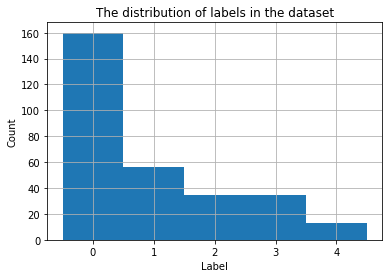

In [3]:
import matplotlib.pyplot as plt

plt.hist(data[:, 13], np.arange(0, 4 + 1.5) - 0.5)
plt.title('The distribution of labels in the dataset')
plt.ylabel('Count')
plt.xlabel('Label')
plt.grid()
plt.show()

$\q{2.2}$ What stands out in this histogram? What does this mean in terms of diagnosis?

We will create a univariate decision tree to decide if an entry belongs to one specific diagnosis or not (binary decision). While decision trees can handle multi-class problems, we will build one to decide for each entry whether it belongs to class $0$ (absence of heart disease) or not.

### Splitting the dataset

In order to train and validate the decision trees, we split the dataset into a training and validation set and separate each of these into three arrays:

1. `x_discrete`, a 2d-array of integers containing the discrete variables for each patient.
2. `x_numeric`, a 2d-array of floats containing the numeric variables for each patient.
3. `y`, a 1d-array of booleans indicating for each patient whether the diagnosis was class 0 or not. This array contains the labels.

In [4]:
# Separate the array into features and labels
x = data[:, :13]
y = data[:, 13]

# Transform classes to booleans
# y = (y == 0), Numpy will repeat this equality check for each entry in the array
# and return an array of booleans.
y = y == np.zeros(len(y))

def split_dataset(x, y, random_state):
    # Split data into train and validation
    from sklearn.model_selection import train_test_split
    
    # For this assignment, we state the random_state variable.
    # This variable will be used as the seed for the random number generation so that the split is deterministic.
    # Therefore, all exercises will give the same results every run.
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.3, random_state=random_state) 

    # Separate features into discrete and numeric arrays. 
    # You can verify that the split (with a boundary of 5) is correct by looking at the data documentation.
    x_train_discrete = x_train[:, np.where(frequencies < 5)[0]].astype(int)
    x_train_numeric = x_train[:, np.where(frequencies > 5)[0]]
    x_validation_discrete = x_validation[:, np.where(frequencies < 5)[0]].astype(int)
    x_validation_numeric = x_validation[:, np.where(frequencies > 5)[0]]
    
    return x_train_discrete, x_train_numeric, x_validation_discrete, x_validation_numeric, y_train, y_validation

x_train_disc, x_train_num, x_validation_disc, x_validation_num, y_train, y_validation = split_dataset(x, y, 42)

$\ex{2.1}$ Print the six arrays and check that the shapes are correct. Verify (with Python assertions) that:
1. `y_train` has the same number of rows as `x_train_disc` and `x_train_num`  
2. `y_validation` has the same number of rows as `x_validation_disc` and `x_validation_num`
3.  there are 8 discrete variables.

In [5]:
# START ANSWER

print(x_train_disc)
print(x_train_num)
print(y_train)

print(x_validation_disc)
print(x_validation_num)
print(y_validation)

assert len(y_train) == x_train_disc.shape[0]
assert len(y_train) == x_train_num.shape[0]

assert len(y_validation) == x_validation_disc.shape[0]
assert len(y_validation) == x_validation_num.shape[0]

assert x_train_disc.shape[1] == 8
assert x_validation_disc.shape[1] == 8

# END ANSWER

[[0 3 0 ... 1 1 3]
 [1 4 0 ... 3 0 7]
 [0 2 0 ... 1 0 3]
 ...
 [1 3 0 ... 2 1 7]
 [1 1 0 ... 1 2 3]
 [0 3 1 ... 1 1 3]]
[[ 67.  152.  277.  172.    0. ]
 [ 59.  170.  326.  140.    3.4]
 [ 34.  118.  210.  192.    0.7]
 ...
 [ 57.  128.  229.  150.    0.4]
 [ 59.  134.  204.  162.    0.8]
 [ 71.  110.  265.  130.    0. ]]
[ True False  True False False False False  True  True  True False False
 False  True  True  True  True False False  True False  True  True  True
  True  True  True False False False False False  True False  True False
 False  True  True False False False False False  True False  True False
  True  True False False False  True  True False False False False False
 False False  True False  True False False  True False  True False  True
  True False False  True False  True False False  True  True  True  True
 False  True False  True  True  True  True  True  True False  True  True
  True False  True  True False  True False  True False False  True False
  True False False 

## 3. Entropy and Information Gain

A decision tree splits a dataset based on the values of certain features. To find the best features and values to split on, we need some way to measure the quality of a split. We will use information gain (which is based on the entropy in the nodes) for this purpose.

<img src="images/entropy-split.png" alt="Entropy Split" style="height: 350px;"/>

*Image retrieved from Ricaud, B. (2017, August 27). A simple explanation of entropy in decision trees.  https://bricaud.github.io/personal-blog/entropy-in-decision-trees*

### Entropy

For decision trees we use the information theoretic entropy, also known as Shannon entropy. It tells us about the amount of information contained in a certain distribution of data.
The best split is the split on a feature that separates most of the "1s" from the "0s" in the resulting two sets. Entropy can thus also be regarded as a measure of purity, and we aim to increase the purity of nodes.

An entropy close to 1.0 indicates that a subset of the data contains an equal number of labels "1" and "0", and thus a split resulting in such subsets is not useful. In the graph below, the relation between entropy and the proportion of data points belonging to one class (in this case '+') in a data set is plotted. As can be seen in the image, the entropy is maximal when the set contains an equal number of "1" and "0" labels. At this point the uncertainty is the highest. The entropy decreases as the data set becomes 'purer'. Our goal is to decrease the entropy by making proper splits.


<img src="images/entropy.png" alt="Entropy" style="height: 350px;"/>

*Image retrieved from Tandon, S. (2019, January 11). Entropy: How Decision Trees Make Decisions. https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8*

The Shannon entropy for any number of classes is given as:

(3.1.a) $$\phi(p) = −\sum_i p_i\ log_2(p_i)$$

As mentioned, we will only decide whether an entry belongs to class $0$ or not: True or False. Thus, in or our case, we can re-write Shannon entropy as follows:

(3.1.b) $$\phi(p) = −p\ log_2(p) − (1 − p)\ log_2(1 − p)$$

where $p$, the probability that an item has label 0, is equivalent to the ratio between the number of items with label $0$ (True) and the number of items with another label (False).


$\ex{3.1}$ First complete the `ratio()` function to compute $p$. The function, given a list of boolean values as class labels, should return the ratio of `True` labels in the list, e.g. $1.0$ would indicate the list only contains `True` labels.

In [6]:
import math

def ratio(labels):
    if len(labels) == 0:
        return 0
    # START ANSWER
    nr_correct = 0
    for i in labels:
        if i == True:
            nr_correct += 1
    return nr_correct / len(labels)
    # END ANSWER
    
print('Ratio for train set:', ratio(y_train))
print('Ratio for validation set:', ratio(y_validation))

# Verify the correctness of the ratio function
assert np.isclose(ratio(y_train), 0.53110)    
assert np.isclose(ratio(y_validation), 0.54444)    

Ratio for train set: 0.5311004784688995
Ratio for validation set: 0.5444444444444444


Next, we compute the entropy. Before we start writing the code, we deal with a possible source of error: the computation of $0\ log_2(0)$ (when $p$ is $0$) will correctly result in a math error.

$\ex{3.2}$ Complete the function `entropy_sub()` to compute the value of the log product. Make sure to return $0$ in the case that $p$ is $0$ instead of an 
error. Then combine `ratio()` and `entropy_sub()` to compute the `entropy()` of a list of boolean class labels.

**Hint:** Use Python's built in `math.log2()` function.

In [7]:
def entropy_sub(p):
    """
    Returns the value for p * log_2(p)
    """
    # START ANSWER
    if(p == 0):
        return 0
    return p * np.log2(p)
    # END ANSWER 
    
def entropy(labels):
    """
    Returns the entropy of an array of labels, computed using equation (3.1.b)
    """
    # START ANSWER
    p = ratio(labels)
    return 0 -entropy_sub(p) - entropy_sub(1 - p)
    # END ANSWER 

print('Entropy for train set:', entropy(y_train))
print('Entropy for validation set:', entropy(y_validation))

# Verify the correctness of the entropy function
assert np.isclose(entropy(y_train), 0.9972)    
assert np.isclose(entropy(y_validation), 0.9943)    

Entropy for train set: 0.9972073335729776
Entropy for validation set: 0.9942929346520454


The entropies of $s$ sets of labels can be combined using a weighted sum:

(3.2) $$I_m = \sum_{j=1}^s \frac{N_j}{N} \phi(p_j)$$

This will give us the overall entropy $I$ of a split on variable $m$, where $N$ is the size of the set before the split, $N_j$ is the size of the $j^{th}$ set after the split, and $\phi(p_j)$ is the entropy of the $j^{th}$ set.

$\ex{3.3}$ Complete the function `split_entropy()` to compute this value for a list of labels and `N`.

In [8]:
def split_entropy(label_lists, N):
    information = 0
    for label_list in label_lists:
        # START ANSWER
        information += entropy(label_list) * label_list.size / N
        # END ANSWER
    return information

# Verify the correctness of the split_entropy function
labels = np.array([0, 0, 0, 0, 1, 1, 1, 1])
N = len(labels)
print('Entropy of the data before splitting:', entropy(labels))

# Worst case split
labels_list = np.array([[0, 0, 1, 1], [0, 0, 1, 1]])
print('Worst case:', split_entropy(labels_list, N))
assert np.isclose(split_entropy(labels_list, N), 1.0)    

# Better split
labels_list = np.array([[0, 0, 0, 1], [1, 1, 1, 0]])
print('Better:', split_entropy(labels_list, N))
assert np.isclose(split_entropy(labels_list, N), 0.81128)    

# Perfect split
labels_list = np.array([[0, 0, 0, 0], [1, 1, 1, 1]])
print('Optimal:', split_entropy(labels_list, N))
assert np.isclose(split_entropy(labels_list, N), 0.0)    

Entropy of the data before splitting: 1.0
Worst case: 1.0
Better: 0.8112781244591328
Optimal: 0.0


### Information Gain

Information Gain (IG) measures how much the entropy changes by making a specific split, i.e. the relative gain in predictability of the data by creating a specific distribution of labels. IG is defined as the entropy of the original distribution $\phi(p)$ minus the entropy of the split distribution $I_m$ resulting from the split on variable $m$.

$$IG_m = \phi(p) - I_m$$

The IG thus depends on two things: 
- the previous list of labels;
- how these labels are divided into new distributions by the split.

$\ex{3.4}$ Complete the `information_gain()` function using the earlier created functions `entropy()` and `split_entropy()`, with as input the previous list of labels (without a split) and a list of indices for each part of the split.

In [9]:
def information_gain(labels, indices): 
    labels_list = []
    for index_list in indices:
        labels_list.append(labels[index_list])
    # START ANSWER
    return entropy(labels) - split_entropy(labels_list, labels.size)
    # END ANSWER
    
labels = np.array([0, 0, 0, 0, 1, 1, 1, 1])
labels_list = np.array([[0, 0, 0, 1], [1, 1, 1, 0]])

# Now we create `indices` that correspond to the indices of the split (compare them with the two lists above). 
# You will have to write code that creates such a list later.
indices = np.array([[0, 1, 2, 4], [5, 6, 7, 3]])

# Verify the correctness of the information_gain function
assert np.isclose(information_gain(labels, indices), 0.18872)    

## 4. Creating Decision Trees

With the data turned into a usable format and the functions to measure entropy and IG ready, we can start building the actual decision tree. Classes are a great way to represent trees: each DecisionTree object class represents a node (or subtree) in the tree and we only have to store references to that node's children to build the structure of the tree. We will distinguish two types of 'nodes':

1. DiscreteTree nodes, split on the basis of the value a discrete variable
2. NumericTree nodes, split on the basis of the value of a numeric variable

Because these two classes are very similar, we will use *inheritance* to avoid redundancy. First we define a parent class `DecisionTree` that will contain all the common elements for `DiscreteTree` and `NumericTree`.

We create a general `DecisionTree` node and then turn it into a `DiscreteTree` or `NumericTree` instance based on the best possible split. This will greatly simplify building a tree which can handle both numeric and discrete splits. The `DecisionTree` class holds all the common functions used for both the `DiscreteTree` and `NumericTree` nodes. Additionally, we will also use its `__init__` method as the generic constructor for either specific type of node. The code to pick the correct concrete class has already been provided, as well as most other logic, so you will only need to focus on completing the split functions for `DiscreteTree` and `NumericTree`.

$\ex{4.1}$ Start by reading the code that has been provided here, so you get a sense of the general structure, and most importantly, what the attributes for each `DecisionTree` nodes are.

In [10]:
from collections import defaultdict

class DecisionTree(object):
    def __init__(self, data_discrete, data_numeric, labels, tree_type=0, thres=0.1):
        """ Creates a Decision Tree, based on the following arguments:
                data_discrete - A 2D array of ints, each row containing the discrete features for a patient.
                data_numeric - A 2D array of floats, each row containing the numeric features for a patient.
                labels - An array of boolean class labels, each corresponding to a
                        DataRow instance of a patient at the same index. 
                tree_type - 0: create the Tree with the highest IG every node 
                            1: create DiscreteTrees only
                            2: create NumericTrees only
                thres - The cutoff value for IG, to stop splitting the tree.
                        Below this value the node becomes a leaf node and no
                        further splits are made.
            N.B. This function has already been provided and does not need to be modified."""
        # Store the basic attributes for any DecisionTree
        self.data_discrete = data_discrete
        self.data_numeric = data_numeric
        self.labels = labels
        self.tree_type = tree_type
        self.thres = thres
        
        # Compute the current ratio of labels and assign this node the most common label
        self.ratio = ratio(self.labels)
        # This will assign a boolean value to self.label, as `self.ratio >= 0.5` is a boolean statement
        self.label = self.ratio >= 0.5
        
        if self.tree_type == 1:
            # Convert this DecisionTree to a DiscreteTree and perform the split
            discr_tree = DiscreteTree(self)
            self.convert_tree(discr_tree)
        elif self.tree_type == 2:
            # Convert this DecisionTree to a NumericTree and perform the split
            numer_tree = NumericTree(self)
            self.convert_tree(numer_tree)
        else:
            # If no specific type has been given (tree_type: 0), we determine which type is best
            # by computing both options and comparing the IG.
            # Create a DiscreteTree and NumericTree, passing all the stored attributes
            # as an argument, and compute the best possible split for each
            discr_tree = DiscreteTree(self)
            numer_tree = NumericTree(self)
            
            # Based on the results of the split computations, replace this generic
            # DecisionTree node with either a DiscreteTree or a NumericTree node
            if discr_tree.info_gain > numer_tree.info_gain:
                self.convert_tree(discr_tree)
            else:
                self.convert_tree(numer_tree)
        
        # Create an empty dictionary to contain the (possible) branches from this node,
        # where the values should be new DecisionTree nodes, or None if not present
        self.branches = defaultdict(lambda: None)
        
        # Check if this split produced a high enough IG to actually create
        # the resulting branches with new split nodes below it,
        # else no split is carried out and the original node is a leaf node
        self.leaf = self.info_gain < self.thres
        if not self.leaf:
            self.create_subtrees()
    
    def store_split_values(self, feat_index, feat_values, indices, info_gain):
        """ Stores the values of the passed parameters as object attributes. Is intended
            to store the results of a split computation for either a DiscreteTree or a
            NumericTree. The stored attributes are:
                feat_index - The index of the feature on which the split was
                    based.
                feat_values - A list of the possible values that this split feature can
                    take, each corresponding to a different branch in the DecisionTree
                indices - A list of index lists, with each list containing the indices
                    defining a subset of the current data and label attributes, as
                    computed by the split. The order of these subsets should match the
                    order of the corresponding feat_values used to define the branches
                    of the split.
                info_gain - IG computed for this split
            N.B. This function has already been provided and does not need to be modified."""
        self.feat_index = feat_index
        self.feat_values = feat_values
        self.indices = indices
        self.info_gain = info_gain
    
    def convert_tree(self, new_tree):
        """ Converts this object to the tree passed as the new_tree parameter.
            All attributes from the new_tree are transfered.
                new_tree - Either a DiscreteTree or a NumericTree instance, to which
                            this object is converted
            N.B. This function has already been provided and does not need to be modified."""
        self.__class__ = new_tree.__class__
        self.__dict__ = new_tree.__dict__
    
    def create_subtrees(self):
        """ Creates the different subsets of the current data and labels, and makes a
            a new DecisionTree node for each such subset, based on the indices attribute
            stored after the computed split. These new DecisionTrees are stored in the 
            branches attribute, a dictionary mapping the value of a variable from the
            split to the new DecisionTree created by selecting that value for the split."""
        for i, key in enumerate(self.feat_values):
            subset_discrete = self.data_discrete[self.indices[i]]
            subset_numeric = self.data_numeric[self.indices[i]]
            subset_labels = self.labels[self.indices[i]]
            subtree = DecisionTree(subset_discrete, subset_numeric, subset_labels, tree_type = self.tree_type)
            self.branches[key] = subtree
        
    def classify(self, row_discrete, row_numeric):
        """ Traverses the DecisionTree based on the values stored in the given row and
            returns the most common label in the resulting leaf node.
                row - The index of the row being classified"""
        # Option 1: node is a leaf
        if self.leaf:
            return self.label
        
        subtree = self.get_subtree(row_discrete, row_numeric)
        
        # Option 2: no valid subtree
        if subtree is None:
            return self.label
        
        # Option 3: there is a valid subtree
        return subtree.classify(row_discrete, row_numeric)
        
    def split(self):
        """ Must be implemented by the subclass based on the specific type of split performed.
            The function here is only to ensure it is implemented, and should not be modified."""
        raise NotImplementedError
    
    def get_subtree(self, instance):
        """ Must be implemented by the subclass based on the specific type of split performed.
            The function here is only to ensure it is implemented, and should not be modified."""
        raise NotImplementedError

### Discrete split

Now you can start actually implementing the `split()` function for the `DiscreteTree`. This function should, for every discrete variable in the data, try to create a split based on that variable and compute the *Information Gain* of the resulting split.

For discrete splits, we split the set into subsets: one for each discrete label. For example, if there are three possible labels for a certain feature, we should return three subsets. The question is: which feature should we pick to split on? You can find out by performing the following steps:
1. For each feature:
    1. Split the set into subsets corresponding to each discrete label.
    2. Compute the information gain for this split.
2. Split the dataset based on the feature with the highest information gain.

Once the best feature for the split has been determined, the results of the split need to be stored in the instance, so they can be used to build the rest of the tree. Let's assume the algorithm decides to split on `chest pain type` (#9). The following attributes should then be stored when splitting:

1. The index of the feature to split on (e.g. 11)
2. A list of discrete options for this feature (e.g. [0, 1, 2, 3], indicating the type of chest pain)
3. A list of indices per option, so the first sublist contains the indices of all rows with chest pain type = 0, etc. (e.g. [[0, 3, 4, 5, 7, 9, ...], [8, ...], [2, 6, ...], [1, ...]])
4. The information gain resulting from the split (e.g. 0.8)

These attributes can then be used to build the rest of the tree.

$\ex{4.2}$ Write the `create_indices_list()` function following the above steps.

__Hint__: You can use `np.unique()` to get the unique values in a list.

$\ex{4.3}$ Complete the `split()` function following the above steps.

__Hint__: Remember to reference attributes of a class using `self`, e.g. `self.data_discrete` instead of `data_discrete`.

In [11]:
def create_indices_list(column):
    """ Creates the indices list, containing for each possible value of the current feature, 
        the indices of corresponding rows (e.g. [[0, 2], [1, 3], ...] where the current
        feature is 0 in rows 0 and 2).
        Returns the list of indices for all feature values and as second output a list of all possible feature values.
            column - The column of one feature from the data."""
    # START ANSWER
    feat_values = np.unique(column)
    indices_list = []
    
    for x in feat_values:
        indices_list.append(np.where(column == x)[0])
    
    return indices_list, feat_values
    # END ANSWER
    
vals = np.array([0, 0, 1, 0, 1, 1, 2, 2])
indices_list, feat_values = create_indices_list(vals)

# Verify the correctness of the create_indices_list function
assert ([[*i] for i in indices_list] == [[0, 1, 3], [2, 4, 5], [6, 7]])
assert np.array_equal(feat_values, [0, 1, 2])

In [12]:
class DiscreteTree(DecisionTree):
    def __init__(self, dtree):
        """ Takes a DecisionTree as initialization parameter and copies all its
            attributes. Then calls the split() function to determine the optimal
            discrete variable to split this subset of the data on.
                dtree - The DecisionTree instance whose attributes are copied to this
                        DiscreteTree instance.
            N.B. This function has already been provided and does not need to be
            modified."""
        self.__dict__ = dtree.__dict__.copy()
        self.split()

    def split(self):
        """ Determines the best discrete variable to split the current dataset on,
            based on the IG resulting from the split. For this best split variable, the
            function stores several resulting attributes from the split, using the
            store_split_values function. See the documentation of store_split_values
            for an overview of what should be stored."""
        max_feat = None
        max_feat_values = None
        max_split = None
        max_ig = 0
        
        for feat in range(self.data_discrete.shape[1]):
            # 1. Call create_indices_list() for the feature column.
            # 2. Compute the IG of the split
            # 3. If IG > max IG, update max values
            
            # START ANSWER
            indices_list, values = create_indices_list(self.data_discrete[:, feat])
            ig = information_gain(self.data_discrete[:, feat], indices_list)
            if(ig > max_ig):
                max_ig = ig
                max_feat = feat
                max_feat_values = values
                max_split = indices_list
            # END ANSWER
            
        self.store_split_values(max_feat, max_feat_values, max_split, max_ig)
            
    def get_subtree(self, row_discrete, row_numeric):
        """ Returns the subtree one branch down.
            Returns None if the value was not present at the split.
                row_discrete - array of the discrete values
                row_numeric - array of the numeric values"""
        value = row_discrete[self.feat_index]
        return self.branches.get(value, None)

### Creating subtrees

If we were to repeat this process of splitting each node, we end up with a tree structure. But we need to stop at a certain moment to avoid building infinite trees and to avoid overfitting.
There are quite a few strategies to decide when to stop. The simplest of these is just to stop splitting when the *Information Gain* of a split drops below a certain threshold.

This is already implemented as the last step in the `__init__` function of `DecisionTree`. The computed IG is compared to the threshold and if the gain is too low, the node is labeled as a leaf node. If the node is not a leaf node, then further splits should be attemped and the `create_subtrees()` function is called to populate the branches of this node with new subset `DecisionTrees`.

$\ex{4.4}$ Take out a pen and paper and try to draw the structure that would be built if you created a new `DecisionTree` using the training data. No need to do the actual entropy math on paper, just try and sketch what objects would be created and how they would relate to each other. If you are having trouble visualizing this for such a large dataset, take a look at the small example tree below.

<img src="images/decision-tree.png" alt="Decision Tree" style="height: 300px;"/>

*Image retrieved from Alpaydin, E. (2010). Introduction to machine learning. Cambridge, Mass.: Mit Press.*

$\ex{4.5}$ Take a look at the `create_subtrees()` function in the `DecisionTree` class above and try to understand how it works.

__Note:__ In order to traverse the decision tree, each new `DecisionTree` should be stored in the `branches` dictionary of the node. Here the *key* should be the value of the discrete variable for that split (stored in `self.feat_values`) and the *value* should be the new `DecisionTree` resulting from that choice in the split. When this dictionary is complete, each key-value pair will represent a different branch of the tree at that split.

### Retrieving subtrees and classifying patient records

The tree building part of the algorithm is complete now! With this structure built, classifying a new patient record is pretty easy. In the code, we refer to a patient record as a row. The patient record is split into a discrete and numeric part: `row_discrete` and `row_numeric`.

$\ex{4.6}$ Take a look at the `get_subtree()` function in `DiscreteTree`, which should return the `DecisionTree` that corresponds to the value of `row_discrete` at the split feature.

The previous exercise gives us a way to traverse the tree, given a patient record. Now, we want to classify the patient record by traversing the tree. At each DecisionTree node, we have three options, based on the type of node:

1. The node is a leaf node, in which case the classification will be the most common label of that node
2. The node does not have a valid subtree for the splitted value, so the classification will also be the node label
3. The node has a subtree for the splitted value, in which case you can recursively continue classifying on the subtree

$\ex{4.7}$ Take a look at the `classify()` function in `DecisionTree`, which should classify a patient record consisting of an array of discrete values and an array of numeric values using the decision tree.

### Validating patient records

$\ex{4.8}$ Finally, write a `validate()` function which takes as input a trained decision tree, a validation set of patient records and corresponding labels, and returns the percentage that is classified correctly.

In [13]:
def validate(decision_tree, data_discrete, data_numeric, labels):
    """ Classifies all patient records and compares the outcome to 
        the provided labels. Returns the percentage of elements that was classified
        correctly.
            data_discrete - A 2D array of ints, each row containing the discrete features for a patient.
            data_numeric - A 2D array of floats, each row containing the numeric features for a patient.
            labels - List of boolean labels each belonging to a patient record"""
    # START ANSWER
    predictions = []
    
    for x, y in zip(data_discrete, data_numeric):
        predictions.append(decision_tree.classify(x, y))
        
    correct_no = (predictions == labels).sum()
    return correct_no / labels.size
    # END ANSWER

$\ex{4.9}$ Create a `DecisionTree` using the training data, with `tree_type` set to $1$ (currently we can only do discrete splits) and print the results when validating with the validation set created earlier.

In [14]:
# Create a DecisionTree called 'trained_decision_tree' with tree_type 1 using the training data
# START ANSWER
trained_decision_tree = DecisionTree(x_train_disc, x_train_num, y_train, 1)
# END ANSWER

# Verify the correctness of the validate function
result = validate(trained_decision_tree, x_validation_disc, x_validation_num, y_validation)
assert np.isclose(result, 0.76667)  

AssertionError: 

## 5. Adding the NumericTree

Now we move on to adding the numeric splits to the tree. All the code already written in the `DecisionTree` class is inherited down to the `NumericTree` class, meaning you will only need to write the two numeric-specific functions.
The most important of these functions is the `split()` function. The numeric split is based on a split boundary, where all values smaller than the boundary are placed in one branch, and those greater or equal in the other branch.

$\ex{5.1}$ Complete the `split()` function in the `NumericTree` class below by implementing the `find_best_split` function. This function tries every possible split boundary for every feature and uses the split with the best IG overall. Think about a logical way to generate all possible ways to separate a set of numeric values into two sets using a split boundary.

__Hint 1__: You do not have to iterate over *all* possible split values. You could just iterate over all values that are present in the dataset, since the values in between make no difference when splitting the data.

__Hint 2__: As a last addition, you should also store the split boundary for this best split, as you will need to compare new values to this same boundary in order to classify them. You can create a new object value, like `self.boundary`.

In [15]:
def find_best_split(data, labels):
    max_feat = None
    max_split = None
    max_ig = 0
    max_boundary = None

    for feat in range(data.shape[1]):
        col = data[:, feat]

        for curr_boundary in col:
            # START ANSWER
            split = [[], []]
            for i, val in enumerate(col):
                if val < curr_boundary:
                    split[0].append(i)
                else:
                    split[1].append(i)
            ig = information_gain(labels, split)
            if(ig > max_ig):
                max_ig = ig
                max_feat = feat
                max_split = split
                max_boundary = curr_boundary
            # END ANSWER
    return max_feat, max_split, max_ig, max_boundary

max_feat, max_split, max_ig, max_boundary = find_best_split(x_train_num[:10,:], y_train[:10])

# Verify the correctness of the find_best_split function
assert ([[*i] for i in max_split] == [[1, 3, 5, 6, 7], [0, 2, 4, 8, 9]])
assert np.array_equal(feat_values, [0, 1, 2])
assert max_feat == 3
assert np.isclose(max_ig, 0.27807)  
assert max_boundary == 159.0  

In [16]:
class NumericTree(DecisionTree):
    def __init__(self, dtree):
        """ Takes a DecisionTree as initialization parameter and copies all its
            attributes. Then calls the split() function to determine the optimal
            numeric variable to split this subset of the data on.
                dtree - The DecisionTree instance whose attributes are copied to this
                        NumericTree instance.
            N.B. This function has already been provided and does not need to be modified."""
        self.__dict__ = dtree.__dict__.copy()
        self.split()

    def split(self):
        """ Determines the best boundary for any numeric variable to split the
            current dataset on, based on the IG resulting from the split. For this
            best split boundary, the function stores several resulting attributes
            from the split, using the store_split_values function. See the
            documentation of store_split_values for an overview of what should
            be stored. In addition, one more attribute is stored in the numeric
            case, namely the boundary value used for the split."""
        max_feat, max_split, max_ig, boundary = find_best_split(self.data_numeric, self.labels)
        self.boundary = boundary
        
        max_feat_values = [False, True]
        self.store_split_values(max_feat, max_feat_values, max_split, max_ig)
        
    def get_subtree(self, row_discrete, row_numeric):
        """ Returns the subtree one branch down.
                row_discrete - array of the discrete values
                row_numeric - array of the numeric values"""
        value = row_numeric[self.feat_index] >= self.boundary
        return self.branches.get(value, None)

$\ex{5.2}$ The second numeric-specific function is the `get_subtree()` function. Take a look at this function in the `NumericTree` class above, which compares the value of the variable on which the split was performed to the split boundary. It uses this to get the correct subtree from the `branches` attribute, where *False* is for the smaller values and *True* for those greater or equal.

## 6. Comparing the Results

Now that the DiscreteTree and NumericTree classes are complete, we can create an actual decision tree.

$\ex{6.1}$ Create three `DecisionTree` instances using the training data, with `tree_type` set to $0$, $1$ and $2$. Tree type 1 will contain only discrete splits, tree type 2 will contain only numeric splits and tree type 0 will try both and use the split with the highest information gain. Print the average validation results for all three trees using the validation set created earlier. Repeat this process for multiple splits of the test set (for `n_iterations`).

**Note**: Do not forget to pass `threshold` (to decide when to stop splitting) when creating a `DecisionTree`, because this parameter will be used in the next exercise.

Keep in mind that the hybrid tree will not necessarily be the most accurate one.

In [17]:
def get_accuracy(threshold = 0.1, n_iterations = 50, standarization=False):
    hybrid_accuracy = 0
    discrete_accuracy = 0
    numeric_accuracy = 0
    
    for i in range(n_iterations):

        x_train_disc, x_train_num, x_validation_disc, x_validation_num, y_train, y_validation = split_dataset(x, y, i)
        
        # START ANSWER
        hybrid_tree = DecisionTree(x_train_disc, x_train_num, y_train, 0, threshold)
        discrete_tree = DecisionTree(x_train_disc, x_train_num, y_train, 1, threshold)
        numeric_tree = DecisionTree(x_train_disc, x_train_num, y_train, 2, threshold)
        
        hybrid_accuracy += validate(hybrid_tree, x_validation_disc, x_validation_num, y_validation)
        discrete_accuracy += validate(discrete_tree, x_validation_disc, x_validation_num, y_validation)
        numeric_accuracy += validate(numeric_tree, x_validation_disc, x_validation_num, y_validation)
        # END ANSWER

    hybrid_accuracy /= n_iterations
    discrete_accuracy /= n_iterations
    numeric_accuracy /= n_iterations
    
    return hybrid_accuracy, discrete_accuracy, numeric_accuracy

hybrid, discrete, numeric = get_accuracy(0.1, standarization=False)

print('Hybrid tree accuracy:', hybrid)
print('Discrete tree accuracy:', discrete)
print('Numeric tree accuracy:', numeric)

# Verify the correctness of the get_accuracy function
assert np.isclose(hybrid, 0.744, rtol=0.05)  
assert np.isclose(discrete, 0.779, rtol=0.05)  
assert np.isclose(numeric, 0.695, rtol=0.05)  

Hybrid tree accuracy: 0.7606666666666668
Discrete tree accuracy: 0.7775555555555559
Numeric tree accuracy: 0.679777777777778


$\ex{6.2}$ Normalize the numeric features in the dataset by using z-score normalization, and use the scaled features to train and evaluate the classifiers. What do you observe in terms of the accuracy compared to the unscaled version?  
**Hint:** Make sure you use the same scaling for both the train and the validation dataset.

In [24]:
def get_accuracy_standardize(threshold = 0.1, n_iterations = 50):
    hybrid_accuracy = 0
    discrete_accuracy = 0
    numeric_accuracy = 0
    
    for i in range(n_iterations):
    
        x_train_disc, x_train_num, x_validation_disc, x_validation_num, y_train, y_validation = split_dataset(x, y, i)
    
        # START ANSWER
        x_train_num = (x_train_num - x_train_num.mean()) / x_train_num.std()
        
        x_validation_num = (x_validation_num - x_validation_num.mean()) / x_validation_num.std()
        # END ANSWER
            
        # START ANSWER
        hybrid_tree = DecisionTree(x_train_disc, x_train_num, y_train, 0, threshold)
        discrete_tree = DecisionTree(x_train_disc, x_train_num, y_train, 1, threshold)
        numeric_tree = DecisionTree(x_train_disc, x_train_num, y_train, 2, threshold)
        
        hybrid_accuracy += validate(hybrid_tree, x_validation_disc, x_validation_num, y_validation)
        discrete_accuracy += validate(discrete_tree, x_validation_disc, x_validation_num, y_validation)
        numeric_accuracy += validate(numeric_tree, x_validation_disc, x_validation_num, y_validation)
        # END ANSWER

    hybrid_accuracy /= n_iterations
    discrete_accuracy /= n_iterations
    numeric_accuracy /= n_iterations
    
    return hybrid_accuracy, discrete_accuracy, numeric_accuracy

hybrid, discrete, numeric = get_accuracy_standardize(0.1)

print('Hybrid tree accuracy:', hybrid)
print('Discrete tree accuracy:', discrete)
print('Numeric tree accuracy:', numeric)

# Verify the correctness of the get_accuracy function
assert np.isclose(hybrid, 0.744, rtol=0.05)  
assert np.isclose(discrete, 0.779, rtol=0.05)  
assert np.isclose(numeric, 0.695, rtol=0.05)

Hybrid tree accuracy: 0.7551111111111111
Discrete tree accuracy: 0.7775555555555559
Numeric tree accuracy: 0.632


AssertionError: 

In order to demonstrate the importance of a good threshold value for the information gain, we are going to plot the accuracy for different threshold values. Note that the code below might run for a few minutes.

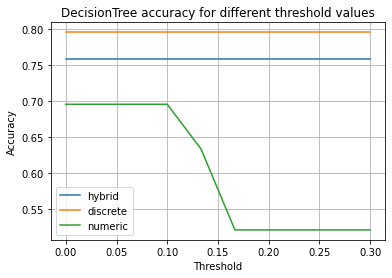

In [25]:
threshold_values = np.linspace(0.00, 0.3, 10)

accuracies_hybrid = []
accuracies_discrete = []
accuracies_numeric = []

for threshold in threshold_values:
    hybrid, discrete, numeric = get_accuracy(threshold, n_iterations=10)
    accuracies_hybrid.append(hybrid)
    accuracies_discrete.append(discrete)
    accuracies_numeric.append(numeric)
    
_, axis = plt.subplots()
axis.plot(threshold_values, accuracies_hybrid, label = 'hybrid')
axis.plot(threshold_values, accuracies_discrete, label = 'discrete')
axis.plot(threshold_values, accuracies_numeric, label = 'numeric')

axis.legend()
axis.set_xlabel('Threshold')
axis.set_ylabel('Accuracy')
plt.title('DecisionTree accuracy for different threshold values')
plt.grid()
plt.show()

## 7. Analysis

If your algorithm is correct and you averaged over enough different validation splits, you might see some strange results in the comparison you just produced. For the last part of the assignment, answer these questions about the results.

$\q{7.1}$ Can you explain how it is possible that the validation score using just the discrete variables is higher than the validation score using the discrete and numeric variables combined? What property of the algorithm makes this outcome possible?

$\q{7.2}$ What is your hypothesis for why this happens for this particular data? What could you do to improve the validation results?

$\q{7.3}$ Think back to the XOR example in the beginning of this assignment. Will the decision tree learning algorithm that you just implemented be able to solve this problem. Why or why not?